# Laser Logger

This notebook is used to develop and test code to connect to the UKUS laser and log characteristics of each laser

In [1]:
# -*- coding: utf-8 -*-
import telnetlib
import datetime 
import sys
import re
import os
import pandas as pd
import numpy as np
import time
from Queue import Queue,Empty
from threading import Thread,Event
import paramiko
import matplotlib.pyplot as plt

In [10]:
os.chdir("Z:/Data")

In [2]:
class ssh_control:
    def __init__(self,user,password,host='155.198.206.24'):
        self.user = user
        self.host = host
        self.password = password
        self.client = self.connect_to_control(user,password)
        
    def connect_to_control(self,user,passwd):
        ssh = paramiko.SSHClient()
        ssh.load_system_host_keys()
        ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh.connect(self.host,username=user,password=passwd)
        return ssh
    
    def __repr__(self):
        return 'SSH session - %s@%s'%(self.user,self.host)
    
    def execute(self,command):
        stdin,stdout,stderr = self.client.exec_command(command)
        return stdout

### Diode Lasers

#### Class Structure

In [ ]:
class LaserReader(Thread):

    def __init__(self, group=None, target=None, name=None,
                 args=(), kwargs=None, verbose=None):
        Thread.__init__(self, group=None, target=target, name=name,
                                  verbose=verbose)
        self.running = True
        self.name = name
        self.args = args
        self.kwargs = kwargs
        
    def run(self):
        out_q = self.kwargs.get('queue')
        while self.running:
            today = datetime.date.today().strftime("%Y/%m/%d")
            if today != self.kwargs['today']:
                    self.kwargs['today'] = today
                    self.set_filename(today)
            data = self.readUKUS()
            out_q.put(data)
            if self.kwargs['log']:
                self.write_to_file(data,self.filename)
            time.sleep(self.kwargs['wait'])
        out_q.put(None)
        
        print 'Laser Reader {name} terminated\n'.format(name = self.name)
        
    def write_to_file(self,data,filename):
        if not os.path.exists(filename):
            print 'Creating New File for', self.kwargs.get('today')
            try:
                os.makedirs(re.match(r'^.*?\_', self.filename).group(0)[:-1])
            except:
                print 'Folder already exists'
            with open(filename,'a+') as f:
                data.to_csv(f,sep=',')
        else:
            with open(filename,'a+') as f:
                data.to_csv(f,sep=',',header=False)
        f.close()

    def readUKUS(self):
        raise(NotImplementedError)

    def set_filename(self,date):
        raise(NotImplementedError)

class ECDL_Reader(LaserReader):
    def __init__(self,kwargs={'queue':Queue()}):
        LaserReader.__init__(self,kwargs=kwargs,name='ECDL')
        self.cols = ['Time', 'absp', 'integerror', 'out0', 'outpid', 
                     'Slave0 pll_error', 'Slave0 pid_out', 'Slave0 ctrl_temp', 
                     'Slave1 pll_error', 'Slave1 pid_out', 'Slave1 ctrl_temp', 
                     'Slave2 pll_error', 'Slave2 pid_out', 'Slave2 ctrl_temp']
        self.host = "192.168.1.118"
        self.set_filename()
        
    def set_filename(self):
        today = datetime.date.today().strftime("%Y%m%d")
        self.filename = os.path.normpath(os.getcwd()+"/" today + "/LaserLog/"+"ecdl.csv")
    def readUKUS(self):
        tn = telnetlib.Telnet(self.host,timeout=60)
        tn.write("ukus autolock_monitor\r\n")
        tn.read_until('state = locked',1)
        data = tn.read_until('MASTER STATE', 1)
        now = str(datetime.datetime.now())
        s=data.split()
        master = [s[30:55:1][i] for i in [0,2,3,5,7,9,10,12,14,16,17,19,21,23]]
        slaves = [s[89:109][i] for i in [0,2,3,5,7,9,10,12,14,16,17,19]]
        tidied=[re.sub(r'(.*H)','', line) for line in master]
        slaves=[re.sub(r'(.*H)','', line) for line in slaves]

        master = [tidied[i] for i in [0,1,4,5,8,9,12,13]]
        slave0 = [tidied[i] for i in [2,3,6,7,10,11]]
        slave1 = [slaves[i] for i in [0,1,4,5,8,9]]
        slave2 = [slaves[i] for i in [2,3,6,7,10,11]]

        master_key=master[0::2]
        master_val=map(float,master[1::2])
        slave0_key = ['Slave0 '+x for x in slave0[0::2]]
        slave0_val = map(float,slave0[1::2])
        slave1_key = ['Slave1 '+x for x in slave0[0::2]]
        slave1_val = map(float,slave1[1::2])
        slave2_key = ['Slave2 '+x for x in slave0[0::2]]
        slave2_val = map(float,slave2[1::2])
        
        d=dict(zip(master_key,master_val)+zip(slave0_key,slave0_val)+zip(slave1_key,slave1_val)+zip(slave2_key,slave2_val))
        return pd.DataFrame(d,index=[now])


class EDFA_Reader(LaserReader):
    def __init__(self,kwargs={'queue':Queue()}):
        LaserReader.__init__(self,kwargs=kwargs,name='EDFA')
        self.host = "192.168.1.75"
        self.set_filename()
        
    def set_filename(self):
        today = datetime.date.today().strftime("%Y%m%d")
        self.filename = os.path.normpath(os.getcwd()+"/"+ today + "/LaserLog/"+"edfa.csv")
    def readUKUS(self):
        tn = telnetlib.Telnet('192.168.1.75',timeout=60)
        tn.write('ukus cplot\r\n')
        tn.read_until("UKUS_RACK_ELEC")
        tn.read_until("UKUS_RACK_ELEC_DISCRETE")
        data = tn.read_until("U")
        now=str(datetime.datetime.now())
        sep_data=[re.sub(r'\x1b(.{,6})H+|    ',',',x) for x in data.splitlines()][2:]
        sep_data[-1]=sep_data[-1][:-5]
        l=[]
        for x in sep_data:
            s = re.split(r',',x)
            [l.append(item) for item in s]
        data = [re.split(':',x) for x in l if 'OK' not in x]
        #deletes the lists with only one element which label the two EDFAs
        data.pop(12)
        data.pop(16)
        data[13][0] = 'EDFA_SLAVE2 Setpoint'
        data[14][0] = 'EDFA_SLAVE2 Output'
        data[15][0] = 'EDFA_SLAVE2 Feedback'
        data[17][0] = 'EDFA_SLAVE1 Setpoint'
        data[18][0] = 'EDFA_SLAVE1 Output'
        data[19][0] = 'EDFA_SLAVE1 Feedback'
        for item in data:
            item[1] = item[1].split('V')[0]
        d=dict(data)
        return pd.DataFrame(d,index=[now])

In [9]:
?iplot

In [4]:
class Plotter(Thread):
    def __init__(self,start_date,end_date,log,name,queue):
         #loads the data to plot
        Thread.__init__(self, group=None, target=None, name=name,
                                  verbose=None)
        self.producer_alive = True
        self.name = name
        self.start_full = start_date
        self.end_full = end_date
        self.start_date = start_date.split('/')
        self.end_date = end_date.split('/')
        self.log = log
        self.df = pd.DataFrame()
        self.queue = queue
    def load(self):
        for year in range(int(self.start_date[0]),int(self.end_date[0])+1):
            for month in range(int(self.start_date[1]),int(self.end_date[1])+1):
                for day in range(int(self.start_date[2]),int(self.end_date[2])+1):
                    filename = "Logs/%02d/%02d/%02d_"% (year,month,day) +self.log+".csv" 
                    try:
                        data = pd.read_csv(filename,index_col = 'Unnamed: 0').dropna()
                        self.df=self.df.append(data)
                    except:
                        pass
    def plot(self,columns,title=None):
        columns = [x for x in columns if x in self.df.columns]
        try:
            data = self.df[columns]
           
            #data = self.df[columns].figure(kind='line')
        except:
            pass
        plot = data.plot(subplots=True,title=title,layout=(len(columns),1))
        return plot
    def plot_all(self):
        raise(NotImplementedError)
        
    def run(self):
        fig, ax  = plt.subplots(4)
        plots = [self.master_plot(),self.slave0_plot(),self.slave1_plot(),self.slave2_plot()]
        
        while self.producer_alive or not self.queue.Empty():
            
            data = self.queue.get()
            self.df = self.df.append(data)
            
            figs = self.plot_all()
            time.sleep(3)
        
  
            
class ECDL_Plotter(Plotter):
    def __init__(self,start_date,end_date,queue=None):
        Plotter.__init__(self,start_date,end_date,'ecdl','ECDLPlotter',queue)
              
    def master_plot(self):
        columns = ['absp', 'integerror', 'out0', 'outpid']
        title = 'Master Laser Log from %s to %s' % (self.start_full,self.end_full)
        return self.plot(columns,title)
   
        
    def slave0_plot(self):
        columns = ['Slave0 ctrl_temp', 'Slave0 pid_out', 'Slave0 pll_error']
        title = 'Slave0 Laser Log from %s to %s' % (self.start_full,self.end_full)
        return self.plot(columns,title)
        
    def slave1_plot(self):
        columns= ['Slave1 ctrl_temp', 'Slave1 pid_out', 'Slave1 pll_error']
        title = 'Slave1 Laser Log from %s to %s' % (self.start_full,self.end_full)
        return self.plot(columns,title)
    def slave2_plot(self):
        columns = ['Slave2 ctrl_temp', 'Slave2 pid_out', 'Slave2 pll_error']
        title = 'Slave2 Laser Log from %s to %s' % (self.start_full,self.end_full)
        return self.plot(columns,title)
    def plot_all(self):
        p1=self.master_plot()
        p2=self.slave0_plot()
        p3=self.slave1_plot()
        p4=self.slave2_plot()
        

class EDFA_Plotter(Plotter):
    def __init__(self,start_date,end_date,queue=None):
        Plotter.__init__(self,start_date,end_date,'edfa','EDFAPlotter',queue)
        
    def edfa0_plot(self):
        columns = ['EDFA_SLAVE0 Current ', 'EDFA_SLAVE0 LM35 ', 'EDFA_SLAVE0 PhdIn ',
       'EDFA_SLAVE0 PhdOut ','EDFA_SLAVE0 Vregul ']
        title = 'EDFA0 Laser Log from %s to %s' % (self.start_full,self.end_full)
        self.plot(columns,title)
    
    def edfa1_plot(self):
        columns = ['EDFA_SLAVE1 Current ', 'EDFA_SLAVE1 LM35 ', 'EDFA_SLAVE1 PhdIn ',
       'EDFA_SLAVE1 PhdOut ', 'EDFA_SLAVE1 Vregul ','EDFA_SLAVE1 Setpoint','EDFA_SLAVE1 Output','EDFA_SLAVE1 Feedback']
        title = 'EDFA1 Laser Log from %s to %s' % (self.start_full,self.end_full)
        self.plot(columns,title)
        
    def edfa2_plot(self):
        columns = ['EDFA_SLAVE2 Current ', 'EDFA_SLAVE2 LM35 ', 'EDFA_SLAVE2 PhdIn ',
                    'EDFA_SLAVE2 PhdOut ', 'EDFA_SLAVE2 Vregul','EDFA_SLAVE2 Setpoint','EDFA_SLAVE2 Output','EDFA_SLAVE2 Feedback']
        title = 'EDFA2 Laser Log from %s to %s' % (self.start_full,self.end_full)
        self.plot(columns,title)
        
    def plot_all(self):
        iplot(self.edfa0_plot())
        iplot(self.edfa1_plot())
        iplot(self.edfa2_plot())

<IPython.core.display.Javascript object>


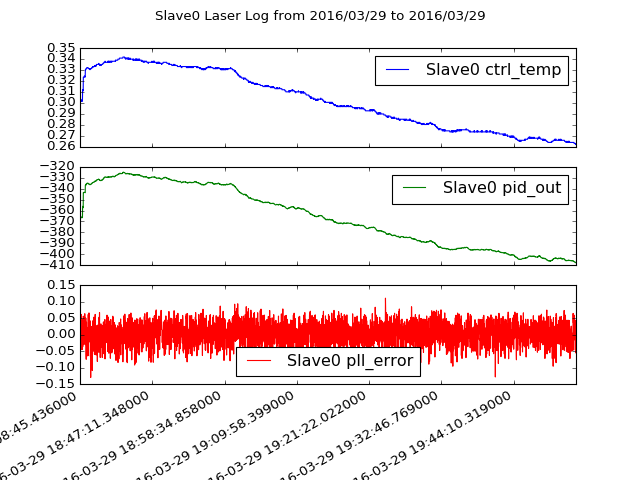

In [59]:
e=ECDL_Plotter('2016/03/29','2016/03/29')
e.load()
s=e.slave0_plot()[0]

In [ ]:
def run():    
    q1=Queue()
    q2=Queue()
    today = datetime.date.today().strftime("%Y%m%d")
    edfa_producer = EDFA_Reader(kwargs={'queue':q2,'today':today,'log':True,'wait':1,'plot':True})
    edfa_producer.start()

    ecdl_producer = ECDL_Reader(kwargs={'queue':q1,'today':today,'log':True,'wait':1,'plot':True})
    ecdl_producer.start()

    producer_pool = [edfa_producer,ecdl_producer]
    ecdl_plotter = ECDL_Plotter(today,today,q1)
    ecdl_plotter.start()

    consumer_pool = [ecdl_plotter]
    while 1:
        control_process = raw_input('Enter Y to Stop Logging: ')
        if control_process == 'Y':
            for producer in producer_pool:
                producer.running = False
                # Joining this to make sure all the producers die
                producer.join()

            for consumer in consumer_pool:
                 #Ideally consumer should stop once producers die
                consumer.producer_alive = False
            break

In [ ]:
run()
Y

In [241]:
e=EDFA_Plotter('2016/03/29','2016/03/29')
e.load()
e.plot_all()

In [242]:
s= e.edfa1_plot()

In [251]:
a=cf.pd.read_csv('Logs/2016/03/23_ecdl.csv')

### Queuing Loggers

In [211]:
tn = telnetlib.Telnet('192.168.1.75',timeout=60)
tn.write('ukus cplot\r\n')
tn.read_until("UKUS_RACK_ELEC")
tn.read_until("UKUS_RACK_ELEC_DISCRETE")
data = tn.read_until("U")
now=str(datetime.datetime.now())
sep_data=[re.sub(r'\x1b(.{,6})H+|    ',',',x) for x in data.splitlines()][2:]
sep_data[-1]=sep_data[-1][:-5]
l=[]
for x in sep_data:
    s = re.split(r',',x)
    [l.append(item) for item in s]
data = [re.split(':',x) for x in l if 'OK' not in x]
#deletes the lists with only one element which label the two EDFAs
data.pop(12)
data.pop(16)
data[13][0] = 'EDFA_SLAVE2 Setpoint'
data[14][0] = 'EDFA_SLAVE2 Output'
data[15][0] = 'EDFA_SLAVE2 Feedback'
data[17][0] = 'EDFA_SLAVE1 Setpoint'
data[18][0] = 'EDFA_SLAVE1 Output'
data[19][0] = 'EDFA_SLAVE1 Feedback'
for item in data:a
    item[1] = item[1].split('V')[0]
d=dict(data)
pd.DataFrame(d,index=[now])

,Diode Rouge LASER ON Slave0,EDFA_SLAVE0 Current,EDFA_SLAVE0 LM35,EDFA_SLAVE0 PhdIn,EDFA_SLAVE0 PhdOut,EDFA_SLAVE0 Vregul,EDFA_SLAVE1 Current,EDFA_SLAVE1 Feedback,EDFA_SLAVE1 LM35,EDFA_SLAVE1 Output,EDFA_SLAVE1 PhdIn,EDFA_SLAVE1 PhdOut,EDFA_SLAVE1 Setpoint,EDFA_SLAVE1 Vregul,EDFA_SLAVE2 Feedback,EDFA_SLAVE2 Output,EDFA_SLAVE2 Setpoint,MON TEMP Rb,PID state
2016-03-30 14:55:22.951000,ON,0.753000,0.311000,3.798000,1.897000,3.029000,0.522000,1.551000,0.286000,2.394520,3.756000,1.548000,1.550000,2.969000,3.001000,2.352478,3.000000,KO,enabled
